## Introduction


In this notebook, I replicated the Gao (2018) paper where they used GMM and Random Forest (RF) to get the membership for M67 open cluster.


## Reference

* Gao, X. (2018). A Machine-learning-based Investigation of the Open Cluster M67. *The Astrophysical Journal*, 869(1). https://doi.org/10.3847/1538-4357/aae8dd

## Replication GMM

Using GMM on the preprocessed data to get a reliable training dataset for Random Forest

### Importing packages

In [1]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.ensemble import RandomForestClassifier

In [2]:
!pip install astroquery

     |████████████████████████████████| 4.5 MB 5.6 MB/s 
     |████████████████████████████████| 832 kB 14.6 MB/s 
     |████████████████████████████████| 54 kB 2.2 MB/s 
     |████████████████████████████████| 3.6 MB 8.3 MB/s 


In [3]:
# import astroquery
import astropy.units as u
import astropy.coordinates as coord
from astroquery.gaia import Gaia
from astroquery.gaia import TapPlus, GaiaClass   
from astroquery.vizier import Vizier


### Finding GAIA Data

In [4]:
## making a GAIA cone_search of 1 degree radius around M67 center
## We are using DR2 as the Gao (2018) paper used DR2

coordinate = coord.SkyCoord.from_name('M67')
print(coordinate)
radius = u.Quantity(1, u.deg)
Gaia.ROW_LIMIT = -1
# table = "gaiaedr3.gaia_source"
table = "gaiadr2.gaia_source"
j = Gaia.cone_search_async(coordinate, radius)
r = j.get_results()
print(type(r))

<SkyCoord (ICRS): (ra, dec) in deg
    (132.846, 11.814)>
INFO: Query finished. [astroquery.utils.tap.core]
<class 'astropy.table.table.Table'>


In [5]:
## save the ASCII table as a panadas dataframe
all_stars = r.to_pandas()
all_stars


,solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_primary_flag,astrometric_weight_al,astrometric_pseudo_colour,astrometric_pseudo_colour_error,mean_varpi_factor_al,...,phot_rp_n_obs,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_rp_excess_factor,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,rv_nb_transits,rv_template_teff,rv_template_logg,rv_template_fe_h,phot_variable_flag,l,b,ecl_lon,ecl_lat,priam_flags,teff_val,teff_percentile_lower,teff_percentile_upper,a_g_val,a_g_percentile_lower,a_g_percentile_upper,e_bp_min_rp_val,e_bp_min_rp_percentile_lower,e_bp_min_rp_percentile_upper,flame_flags,radius_val,radius_percentile_lower,radius_percentile_upper,lum_val,lum_percentile_lower,lum_percentile_upper,datalink_url,dist
0,1635721458409799680,Gaia DR2 604917629355038848,604917629355038848,309606362,2015.5,132.845427,0.033842,11.813721,0.022365,1.129222,0.042616,26.497473,-10.956961,0.071723,-3.093306,0.051006,-0.195550,-0.170198,-0.157318,-0.074163,0.217768,0.129410,-0.505363,0.261068,0.050572,-0.386716,270,270,268,2,6.030247,426.040680,0.000000,0.000000e+00,31,True,245.371384,1.627914,0.006196,0.055473,...,29,114671.304674,76.650655,1496.025146,12.113283,1.204024,1,0.741670,0.292775,0.448895,NaN,NaN,0,NaN,NaN,NaN,NOT_AVAILABLE,215.691180,31.920163,131.975615,-5.602846,100002,6320.979980,6052.333496,6652.666504,NaN,NaN,NaN,NaN,NaN,NaN,200111,1.939404,1.750837,2.115395,5.409647,5.116649,5.702646,https://gea.esac.esa.int/data-server/datalink/...,0.000629
1,1635721458409799680,Gaia DR2 604917698073552640,604917698073552640,524821416,2015.5,132.842932,0.678479,11.812019,0.385532,1.326860,0.821405,1.615354,-4.899287,1.382265,-3.937188,0.926115,-0.158810,-0.202182,-0.277384,-0.048904,0.174523,0.192990,-0.644295,0.224496,0.102105,-0.366163,282,0,281,1,-0.289480,268.599243,0.000000,0.000000e+00,31,False,0.059617,1.499148,0.113118,0.078844,...,32,343.700852,8.615749,39.892162,18.421469,2.536617,0,2.095335,0.400385,1.694950,NaN,NaN,0,NaN,NaN,NaN,NOT_AVAILABLE,215.691796,31.917233,131.973718,-5.605147,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,https://gea.esac.esa.int/data-server/datalink/...,0.003599
2,1635721458409799680,Gaia DR2 604917732434252032,604917732434252032,1037136882,2015.5,132.847883,0.047155,11.818284,0.028357,1.113444,0.059270,18.785810,-11.261058,0.099747,-3.060736,0.069823,-0.203317,-0.193954,-0.088213,-0.091070,0.198510,0.143394,-0.505099,0.266576,0.071134,-0.393377,305,0,304,1,-0.531459,285.544067,0.000000,0.000000e+00,31,False,9.124626,1.523387,0.008625,0.048264,...,27,6389.556146,26.115426,244.665970,15.248243,1.261143,0,1.213900,0.520187,0.693712,NaN,NaN,0,NaN,NaN,NaN,NOT_AVAILABLE,215.687482,31.924256,131.976693,-5.597801,100001,4880.000000,4811.924805,5016.500000,NaN,NaN,NaN,NaN,NaN,NaN,200111,0.748697,0.708507,0.770030,0.286409,0.253650,0.319167,https://gea.esac.esa.int/data-server/datalink/...,0.004667
3,1635721458409799680,Gaia DR2 604917732434325248,604917732434325248,1685360922,2015.5,132.845628,0.023422,11.820310,0.014362,1.125087,0.028212,39.879951,-10.902709,0.049980,-3.153121,0.033065,-0.114846,-0.047632,-0.194107,-0.122447,0.224214,0.041213,-0.483801,0.205225,0.025290,-0.329040,263,0,258,5,1.481120,287.074982,0.062990,1.277349e+00,31,False,83.750946,1.654632,0.003962,0.068040,...,28,62416.143422,47.694076,1308.677124,12.773678,1.201937,0,0.629848,0.236272,0.393577,NaN,NaN,0,NaN,NaN,NaN,NOT_AVAILABLE,215.684227,31.923100,131.974

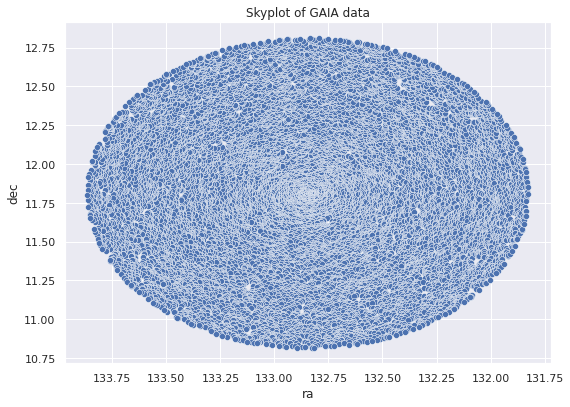

In [6]:
## plotting the skyplot 

sns.set(rc={'figure.figsize':(8.7,6.27)})

skyplot = sns.scatterplot(x='ra', y='dec', data = all_stars)
skyplot.invert_xaxis()
plt.title('Skyplot of GAIA data')
plt.show()

### Applying Filter:

In [7]:
# calculating the distance from the parallax
all_stars['distance_pc'] = 1/(all_stars.parallax*0.001)

In [8]:
print(len(all_stars))

# positive parallax
all_stars = all_stars[all_stars['parallax'] >= 0]
print(len(all_stars))

# dropping rows with null values in required columns
all_stars = all_stars[all_stars.loc[:, 'pmra'].notnull()]
all_stars = all_stars[all_stars.loc[:, 'parallax'].notnull()]
all_stars = all_stars[all_stars.loc[:, 'bp_rp'].notnull()]
print(len(all_stars))

# defining proper motion (pm) range
all_stars = all_stars[(abs(all_stars['pmra']) <= 20) & (abs(all_stars['pmdec']) <= 20)]
print(len(all_stars))

# taking stars within 60' = 1 deg radius
all_stars = all_stars[all_stars['dist'] < (60/60)]
print(len(all_stars))

# taking stars within a distance of 500 - 1600 pc
all_stars = all_stars[((all_stars['distance_pc']) < 1600) & ((all_stars['distance_pc']) > 500)]
print(len(all_stars))


19423
14198
14098
12972
12972
7316


### Building GMM Model

In [21]:
def get_member(working_data, feature_columns, cutoff = 0.6):
    features = working_data.loc[:,feature_columns].dropna()

    if len(working_data) < 2:
        raise ValueError('Less than two stars in the data')
    
    # normalizing the features
    scaled_features = pd.DataFrame({})
    for column in features.columns:
        scaled_features[column] = (features[column] - np.median(features[column]))/np.std(features[column])

    from sklearn.mixture import GaussianMixture
    gmm = GaussianMixture(n_components=2, n_init = 5, random_state=42)
    gmm.fit(scaled_features)

    # predictions from gmm
    labels = gmm.predict(scaled_features)
    probs = gmm.predict_proba(scaled_features)

    working_data.loc[:, 'PMemb'] = probs[:, 0]
    working_data.loc[:, 'gmm_label'] = labels

    non_member_ind = working_data.loc[:, 'PMemb'] <= (1-cutoff)
    non_member = working_data.loc[non_member_ind, :]
    
    member_ind = working_data.loc[:, 'PMemb'] >= cutoff
    member = working_data.loc[member_ind, :]

    if np.std(member.pmra) > np.std(non_member.pmra):
        working_data.loc[:, 'PMemb'] = probs[:, 1]
        working_data.loc[:, 'gmm_label'] = 1-labels
        
        non_member_ind = working_data.loc[:, 'PMemb'] <= (1-cutoff)
        non_member = working_data.loc[non_member_ind, :]
        
        member_ind = working_data.loc[:, 'PMemb'] >= cutoff
        member = working_data.loc[member_ind, :]
    
    return member, non_member, gmm

In [22]:
feature_columns = ['pmra', 'pmdec', 'ra', 'dec', 'parallax']

member, non_member, gmm = get_member(all_stars, feature_columns, cutoff=0.6)

In [23]:
def get_MSS_metric(member, non_member, feature_columns):
    # get modified silhouttee score from the given member and non_member

    if len(member) < 2 or len(non_member) < 2:
        return 0
    
    metric = np.zeros(len(feature_columns))
    for i in range(len(feature_columns)):
        feature_i = feature_columns[i]
        metric[i] = (np.std(non_member[feature_i]) - np.std(member[feature_i])) \
                / max(np.std(member[feature_i]), np.std(non_member[feature_i]), 1e-7)

    return metric.mean()

In [24]:
get_MSS_metric(member, non_member, feature_columns)

0.6985752332446376

### Comparing with Gao Paper

#### Members and Covariance Matrix

Depending on the cutoff on PMemb, the number of stars are following:
* Likely member (PMemb >= 0.6) = 1401
* High-probability member (PMemb >= 0.95) = 1256
* Zero-probability field star (PMemb = 0) = 5720

And the covariance matrix for field stars group, $\sum_f$ and the member group $\sum_c$ are following:


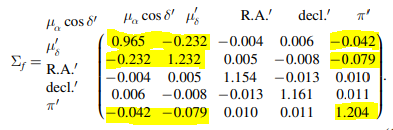

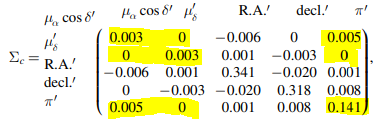

In [25]:
gmm.covariances_.round(3)

array([[[ 9.630e-01, -2.320e-01, -5.000e-03,  4.000e-03, -4.200e-02],
        [-2.320e-01,  1.235e+00,  5.000e-03, -1.000e-02, -7.900e-02],
        [-5.000e-03,  5.000e-03,  1.157e+00, -1.300e-02,  8.000e-03],
        [ 4.000e-03, -1.000e-02, -1.300e-02,  1.163e+00,  7.000e-03],
        [-4.200e-02, -7.900e-02,  8.000e-03,  7.000e-03,  1.205e+00]],

       [[ 3.000e-03, -0.000e+00, -6.000e-03, -0.000e+00,  5.000e-03],
        [-0.000e+00,  3.000e-03,  1.000e-03, -3.000e-03, -0.000e+00],
        [-6.000e-03,  1.000e-03,  3.420e-01, -2.000e-02, -0.000e+00],
        [-0.000e+00, -3.000e-03, -2.000e-02,  3.210e-01,  7.000e-03],
        [ 5.000e-03, -0.000e+00, -0.000e+00,  7.000e-03,  1.480e-01]]])

In [26]:
len(member), len(non_member)

(1414, 5870)

In [27]:
print('n(PMemb >= 0.6) =', sum(all_stars.PMemb >= 0.6))
print('n(PMemb >= 0.95) =', sum(all_stars.PMemb >= 0.95))
print('n(PMemb <= 0.0001) =', sum(all_stars.PMemb <= 0.0001))

n(PMemb >= 0.6) = 1414
n(PMemb >= 0.95) = 1260
n(PMemb <= 0.0001) = 5693


#### Figure 1
PMemb histogram and the plot for PMemb vs G band magnitude.

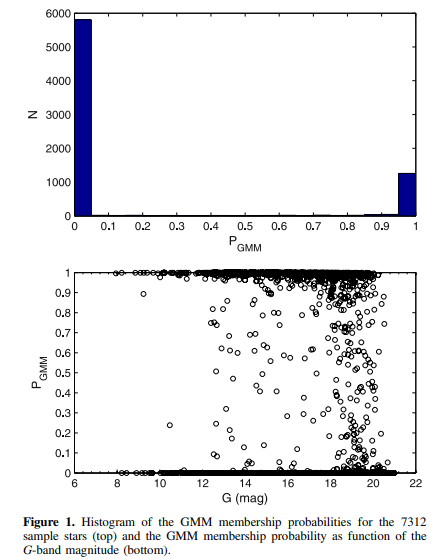


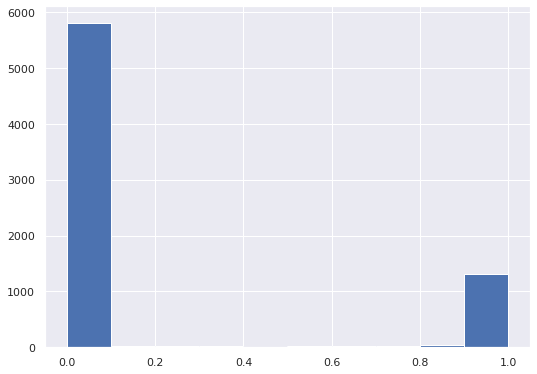

In [ ]:
plt.hist(all_stars.PMemb)
plt.show()

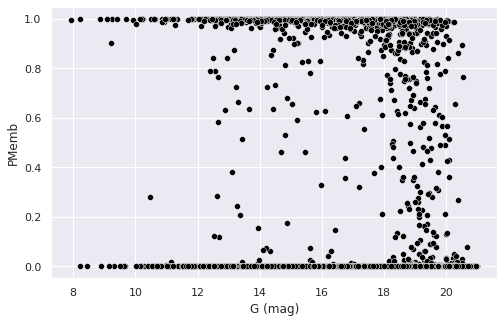

In [28]:
plt.figure(figsize=(8,5))
sns.scatterplot(x='phot_g_mean_mag', y = 'PMemb', data = all_stars, color = 'black')
plt.xlabel('G (mag)')
plt.show()

#### Figure 2
Proper Motion Plot

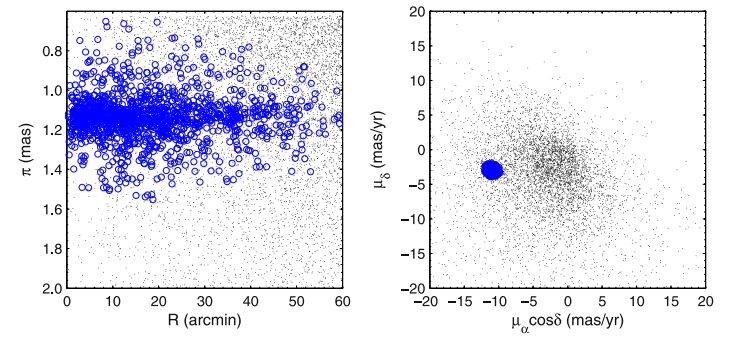

In [ ]:
training_data = pd.concat([member.assign(member=1), non_member.assign(member=0)])
training_data.head()

,solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_primary_flag,astrometric_weight_al,astrometric_pseudo_colour,astrometric_pseudo_colour_error,mean_varpi_factor_al,...,phot_rp_mean_mag,phot_bp_rp_excess_factor,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,rv_nb_transits,rv_template_teff,rv_template_logg,rv_template_fe_h,phot_variable_flag,l,b,ecl_lon,ecl_lat,priam_flags,teff_val,teff_percentile_lower,teff_percentile_upper,a_g_val,a_g_percentile_lower,a_g_percentile_upper,e_bp_min_rp_val,e_bp_min_rp_percentile_lower,e_bp_min_rp_percentile_upper,flame_flags,radius_val,radius_percentile_lower,radius_percentile_upper,lum_val,lum_percentile_lower,lum_percentile_upper,datalink_url,dist,distance_pc,PMemb,gmm_label,member
0,1635721458409799680,Gaia DR2 604917629355038848,604917629355038848,309606362,2015.5,132.845427,0.033842,11.813721,0.022365,1.129222,0.042616,26.497473,-10.956961,0.071723,-3.093306,0.051006,-0.195550,-0.170198,-0.157318,-0.074163,0.217768,0.129410,-0.505363,0.261068,0.050572,-0.386716,270,270,268,2,6.030247,426.040680,0.000000,0.000000,31,True,245.371384,1.627914,0.006196,0.055473,...,12.113283,1.204024,1,0.741670,0.292775,0.448895,NaN,NaN,0,NaN,NaN,NaN,NOT_AVAILABLE,215.691180,31.920163,131.975615,-5.602846,100002,6320.979980,6052.333496,6652.666504,NaN,NaN,NaN,NaN,NaN,NaN,200111,1.939404,1.750837,2.115395,5.409647,5.116649,5.702646,https://gea.esac.esa.int/data-server/datalink/...,0.000629,885.565629,0.999431,0,1
2,1635721458409799680,Gaia DR2 604917732434252032,604917732434252032,1037136882,2015.5,132.847883,0.047155,11.818284,0.028357,1.113444,0.059270,18.785810,-11.261058,0.099747,-3.060736,0.069823,-0.203317,-0.193954,-0.088213,-0.091070,0.198510,0.143394,-0.505099,0.266576,0.071134,-0.393377,305,0,304,1,-0.531459,285.544067,0.000000,0.000000,31,False,9.124626,1.523387,0.008625,0.048264,...,15.248243,1.261143,0,1.213900,0.520187,0.693712,NaN,NaN,0,NaN,NaN,NaN,NOT_AVAILABLE,215.687482,31.924256,131.976693,-5.597801,100001,4880.000000,4811.924805,5016.500000,NaN,NaN,NaN,NaN,NaN,NaN,200111,0.748697,0.708507,0.770030,0.286409,0.253650,0.319167,https://gea.esac.esa.int/data-server/datalink/...,0.004667,898.114453,0.999205,0,1
3,1635721458409799680,Gaia DR2 604917732434325248,604917732434325248,1685360922,2015.5,132.845628,0.023422,11.820310,0.014362,1.125087,0.028212,39.879951,-10.902709,0.049980,-3.153121,0.033065,-0.114846,-0.047632,-0.194107,-0.122447,0.224214,0.041213,-0.483801,0.205225,0.025290,-0.329040,263,0,258,5,1.481120,287.074982,0.062990,1.277349,31,False,83.750946,1.654632,0.003962,0.068040,...,12.773678,1.201937,0,0.629848,0.236272,0.393577,NaN,NaN,0,NaN,NaN,NaN,NOT_AVAILABLE,215.684227,31.923100,131.974006,-5.596452,100001,6845.333496,6356.000000,6994.666504,0.2835,0.1735,0.5501,0.1392,0.0740,0.2746,200111,1.255830,1.202780,1.456640,3.119858,2.927116,3.312600,https://gea.esac.esa.int/data-server/datalink/...,0.006326,888.820446,0.999328,0,1
4,1635721458409799680,Gaia DR2 604917629355039360,604917629355039360,340729517,2015.5,132.846939,0.039546,11.807362,0.023041,1.111626,0.047573,23.366507,-10.978362,0.085649,-3.395680,0.056500,-0.188175,-0.164693,0.031988,-0.101328,0.184592,0.083166,-0.472924,0.213145,0.061962,-0.342663,288,0,288,0,12.284073,686.185303,0.226969,13.566716,31,False,14.085754,1.546124,0.006565,0.058586,...,13.436893,1.238919,0,1.079499,0.455420,0.624079,NaN,NaN,0,NaN,NaN,NaN,NOT_AVAILABLE,215.698714,31.918846,131.978783,-5.608563,100001,4932.049805,4844.333496,5044.100098,1.09

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


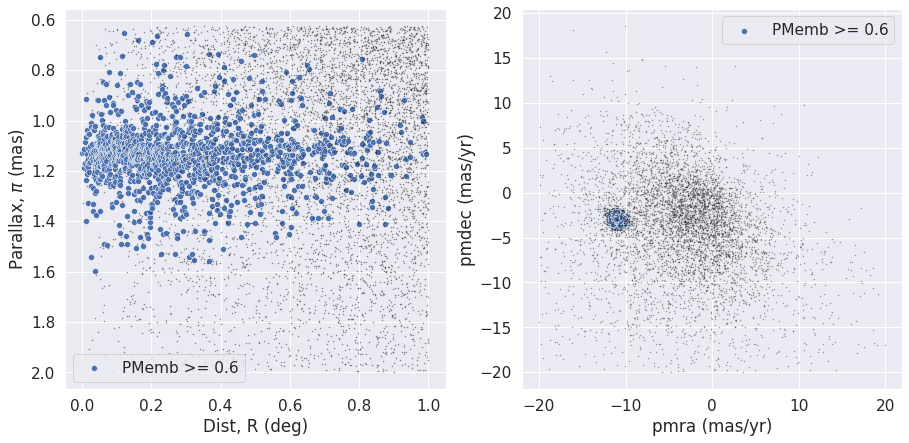

In [ ]:
sns.set(font_scale = 1.4)

plt.figure(figsize = (15,7))

plt.subplot(121)
plt.plot(non_member['dist'], non_member['parallax'], 'k.',  alpha = 0.5,
         markersize = 1)
plt.gca().invert_yaxis()
sns.scatterplot('dist', 'parallax', data = member, label = 'PMemb >= 0.6')
plt.xlabel('Dist, R (deg)')
plt.ylabel('Parallax, $\pi$ (mas)')
plt.legend()
#plt.title('Member')

plt.subplot(122)
plt.plot(non_member['pmra'], non_member['pmdec'], 'k.', alpha = 0.4, 
         markersize = 1)
sns.scatterplot('pmra', 'pmdec', data = member, label = 'PMemb >= 0.6')
plt.ylabel('pmdec (mas/yr)')
plt.xlabel('pmra (mas/yr)')
plt.legend()
#plt.title('Non Member')
plt.show()

#### Figure 3: CMD
Color-Magnitude Diagram

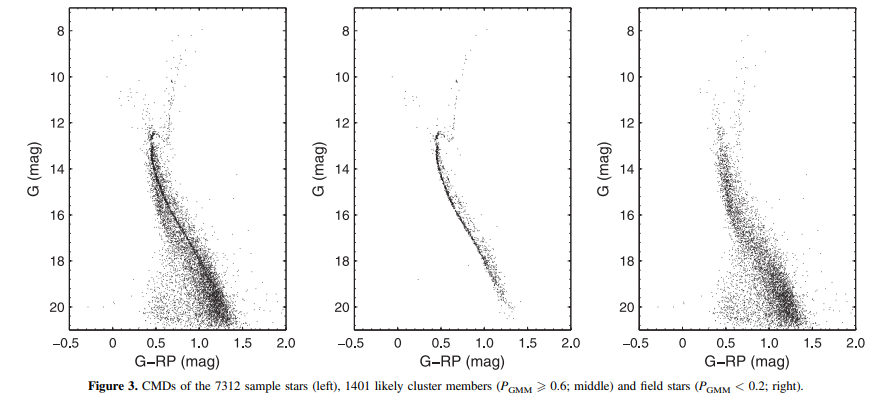

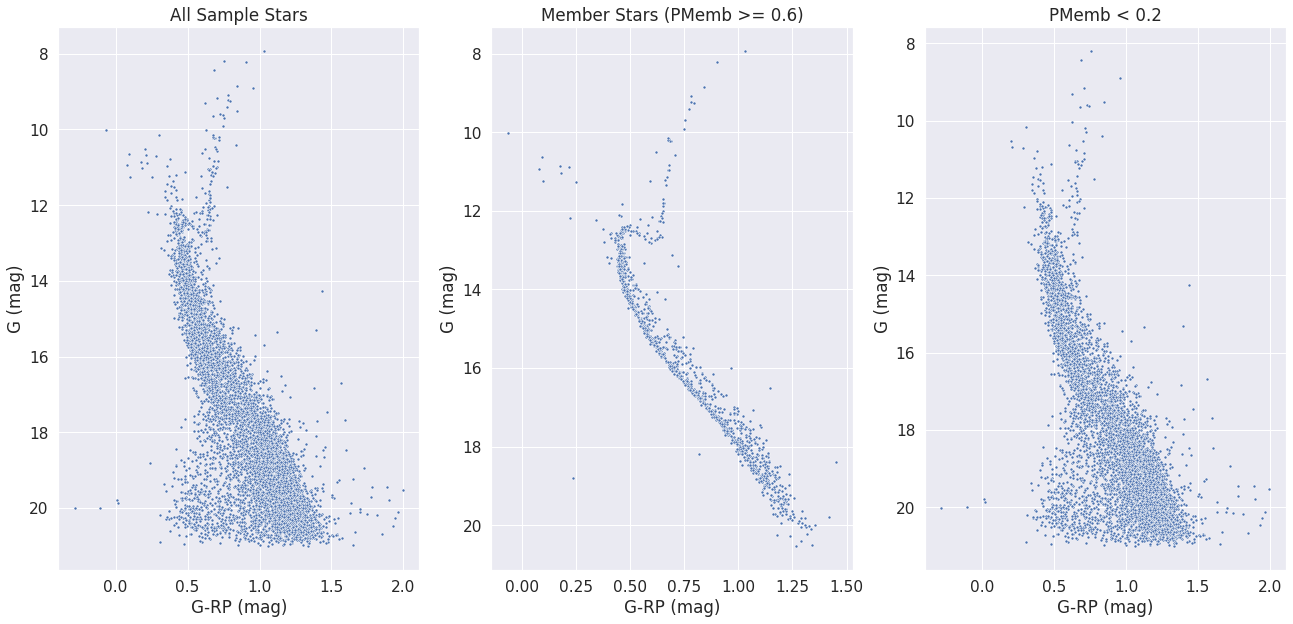

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(22,10))
#fig.suptitle('CMD of Training data for M67')

sns.scatterplot(x = 'g_rp', y='phot_g_mean_mag',
                data = training_data, ax = axes[0], marker = '.')
axes[0].set_title('All Sample Stars')
axes[0].set_xlabel('G-RP (mag)')
axes[0].set_ylabel('G (mag)')
axes[0].invert_yaxis()

sns.scatterplot(x = 'g_rp', y='phot_g_mean_mag', marker = '.',
                data = member, ax = axes[1])
axes[1].set_title('Member Stars (PMemb >= 0.6)')
axes[1].set_xlabel('G-RP (mag)')
axes[1].set_ylabel('G (mag)')
axes[1].invert_yaxis()

sns.scatterplot(x = 'g_rp', y='phot_g_mean_mag',  marker = '.',
                data = non_member[non_member.PMemb < 0.2], ax = axes[2])
axes[2].set_title('PMemb < 0.2')
axes[2].invert_yaxis()
axes[2].set_xlabel('G-RP (mag)')
axes[2].set_ylabel('G (mag)')

plt.show()


#### Distribution of features

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

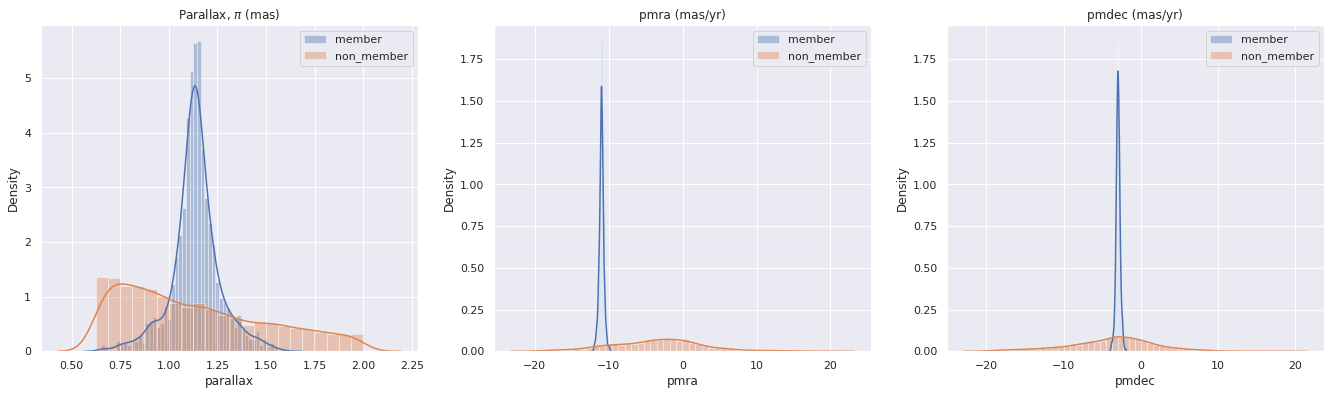

In [29]:
plt.figure(figsize = (23,6))

plt.subplot(131)
sns.distplot(member.parallax, label='member')
sns.distplot(non_member.parallax, label = 'non_member')
plt.title('Parallax, $\pi$ (mas)')
plt.legend()

plt.subplot(132)
sns.distplot(member.pmra, label='member')
sns.distplot(non_member.pmra, label = 'non_member')
plt.title('pmra (mas/yr)')
plt.legend()

plt.subplot(133)
sns.distplot(member.pmdec, label='member')
sns.distplot(non_member.pmdec, label = 'non_member')
plt.title('pmdec (mas/yr)')
plt.legend()

plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

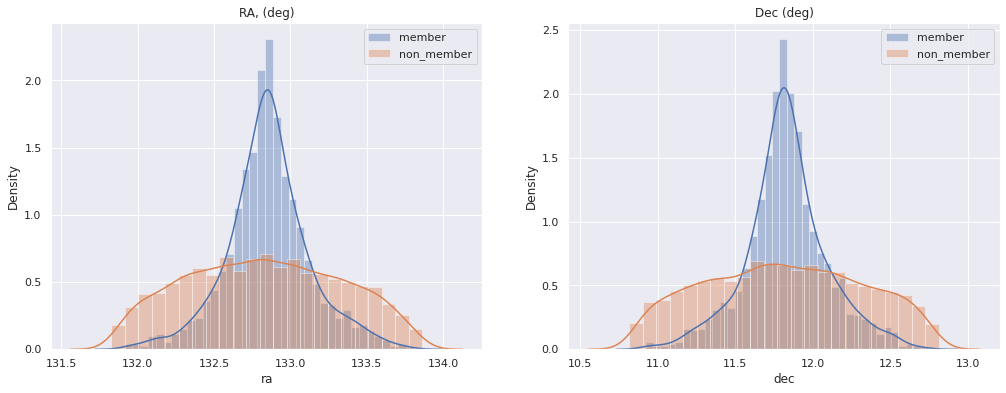

In [30]:
plt.figure(figsize = (17,6))

plt.subplot(121)
sns.distplot(member.ra, label='member')
sns.distplot(non_member.ra, label = 'non_member')
plt.title('RA, (deg)')
plt.legend()

plt.subplot(122)
sns.distplot(member.dec, label='member')
sns.distplot(non_member.dec, label = 'non_member')
plt.title('Dec (deg)')
plt.legend()

plt.show()

## Replication: Random Forest

Here we used the training data retrieved from GMM model to train a random forest model. Then predicted the cluster membership for a larger radius (2.5 degree) around the cluster center.

In [31]:
# Building GMM Model again

feature_columns = ['pmra', 'pmdec', 'ra', 'dec', 'parallax']

member, non_member, gmm = get_member(all_stars, feature_columns, cutoff=0.95)

In [34]:
MSS_95 = get_MSS_metric(member, non_member, feature_columns)
MSS_95

0.7290151802832335

### Training Data

In [32]:
member = member[member.PMemb >= 0.95]
non_member = non_member[non_member.PMemb <= 0.0001]

training_data = pd.concat([member.assign(member=1), non_member.assign(member=0)])
training_data.head()

,solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_primary_flag,astrometric_weight_al,astrometric_pseudo_colour,astrometric_pseudo_colour_error,mean_varpi_factor_al,...,phot_rp_mean_mag,phot_bp_rp_excess_factor,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,rv_nb_transits,rv_template_teff,rv_template_logg,rv_template_fe_h,phot_variable_flag,l,b,ecl_lon,ecl_lat,priam_flags,teff_val,teff_percentile_lower,teff_percentile_upper,a_g_val,a_g_percentile_lower,a_g_percentile_upper,e_bp_min_rp_val,e_bp_min_rp_percentile_lower,e_bp_min_rp_percentile_upper,flame_flags,radius_val,radius_percentile_lower,radius_percentile_upper,lum_val,lum_percentile_lower,lum_percentile_upper,datalink_url,dist,distance_pc,PMemb,gmm_label,member
0,1635721458409799680,Gaia DR2 604917629355038848,604917629355038848,309606362,2015.5,132.845427,0.033842,11.813721,0.022365,1.129222,0.042616,26.497473,-10.956961,0.071723,-3.093306,0.051006,-0.195550,-0.170198,-0.157318,-0.074163,0.217768,0.129410,-0.505363,0.261068,0.050572,-0.386716,270,270,268,2,6.030247,426.040680,0.000000,0.000000,31,True,245.371384,1.627914,0.006196,0.055473,...,12.113283,1.204024,1,0.741670,0.292775,0.448895,NaN,NaN,0,NaN,NaN,NaN,NOT_AVAILABLE,215.691180,31.920163,131.975615,-5.602846,100002,6320.979980,6052.333496,6652.666504,NaN,NaN,NaN,NaN,NaN,NaN,200111,1.939404,1.750837,2.115395,5.409647,5.116649,5.702646,https://gea.esac.esa.int/data-server/datalink/...,0.000629,885.565629,0.999441,0,1
2,1635721458409799680,Gaia DR2 604917732434252032,604917732434252032,1037136882,2015.5,132.847883,0.047155,11.818284,0.028357,1.113444,0.059270,18.785810,-11.261058,0.099747,-3.060736,0.069823,-0.203317,-0.193954,-0.088213,-0.091070,0.198510,0.143394,-0.505099,0.266576,0.071134,-0.393377,305,0,304,1,-0.531459,285.544067,0.000000,0.000000,31,False,9.124626,1.523387,0.008625,0.048264,...,15.248243,1.261143,0,1.213900,0.520187,0.693712,NaN,NaN,0,NaN,NaN,NaN,NOT_AVAILABLE,215.687482,31.924256,131.976693,-5.597801,100001,4880.000000,4811.924805,5016.500000,NaN,NaN,NaN,NaN,NaN,NaN,200111,0.748697,0.708507,0.770030,0.286409,0.253650,0.319167,https://gea.esac.esa.int/data-server/datalink/...,0.004667,898.114453,0.999214,0,1
3,1635721458409799680,Gaia DR2 604917732434325248,604917732434325248,1685360922,2015.5,132.845628,0.023422,11.820310,0.014362,1.125087,0.028212,39.879951,-10.902709,0.049980,-3.153121,0.033065,-0.114846,-0.047632,-0.194107,-0.122447,0.224214,0.041213,-0.483801,0.205225,0.025290,-0.329040,263,0,258,5,1.481120,287.074982,0.062990,1.277349,31,False,83.750946,1.654632,0.003962,0.068040,...,12.773678,1.201937,0,0.629848,0.236272,0.393577,NaN,NaN,0,NaN,NaN,NaN,NOT_AVAILABLE,215.684227,31.923100,131.974006,-5.596452,100001,6845.333496,6356.000000,6994.666504,0.2835,0.1735,0.5501,0.1392,0.0740,0.2746,200111,1.255830,1.202780,1.456640,3.119858,2.927116,3.312600,https://gea.esac.esa.int/data-server/datalink/...,0.006326,888.820446,0.999338,0,1
4,1635721458409799680,Gaia DR2 604917629355039360,604917629355039360,340729517,2015.5,132.846939,0.039546,11.807362,0.023041,1.111626,0.047573,23.366507,-10.978362,0.085649,-3.395680,0.056500,-0.188175,-0.164693,0.031988,-0.101328,0.184592,0.083166,-0.472924,0.213145,0.061962,-0.342663,288,0,288,0,12.284073,686.185303,0.226969,13.566716,31,False,14.085754,1.546124,0.006565,0.058586,...,13.436893,1.238919,0,1.079499,0.455420,0.624079,NaN,NaN,0,NaN,NaN,NaN,NOT_AVAILABLE,215.698714,31.918846,131.978783,-5.608563,100001,4932.049805,4844.333496,5044.100098,1.09

In [35]:
# Examining the descriptive statistics of each column
training_data.describe()

,solution_id,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_weight_al,astrometric_pseudo_colour,astrometric_pseudo_colour_error,mean_varpi_factor_al,astrometric_matched_observations,visibility_periods_used,...,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_rp_excess_factor,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,rv_nb_transits,rv_template_teff,rv_template_logg,rv_template_fe_h,l,b,ecl_lon,ecl_lat,priam_flags,teff_val,teff_percentile_lower,teff_percentile_upper,a_g_val,a_g_percentile_lower,a_g_percentile_upper,e_bp_min_rp_val,e_bp_min_rp_percentile_lower,e_bp_min_rp_percentile_upper,flame_flags,radius_val,radius_percentile_lower,radius_percentile_upper,lum_val,lum_percentile_lower,lum_percentile_upper,dist,distance_pc,PMemb,gmm_label,member
count,6.953000e+03,6.953000e+03,6.953000e+03,6953.0,6953.000000,6953.000000,6953.000000,6953.000000,6953.000000,6953.000000,6953.000000,6953.000000,6953.000000,6953.000000,6953.000000,6953.000000,6953.000000,6953.000000,6953.000000,6953.000000,6953.000000,6953.000000,6953.000000,6953.000000,6953.000000,6953.000000,6953.000000,6953.000000,6953.000000,6953.000000,6953.000000,6953.000000,6953.000000,6953.0,6953.000000,6947.000000,6947.000000,6953.000000,6953.000000,6953.000000,...,6953.000000,6953.000000,6953.000000,6953.000000,6953.000000,6953.000000,6953.000000,6953.000000,172.000000,172.000000,6953.000000,172.000000,172.000000,172.000000,6953.000000,6953.000000,6953.000000,6953.000000,2509.000000,2509.000000,2509.000000,2509.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2425.0,2425.000000,2425.000000,2425.000000,2425.000000,2425.000000,2425.000000,6953.000000,6953.000000,6.953000e+03,6953.000000,6953.000000
mean,1.635721e+18,6.035150e+17,8.538968e+08,2015.5,132.832621,0.304849,11.815894,0.198779,1.128875,0.383054,10.780026,-4.616915,0.639824,-3.604515,0.429209,-0.314180,-0.228378,-0.275257,0.158710,0.239933,0.290639,-0.684020,0.428231,-0.152229,-0.401461,322.458363,12.958004,320.156192,2.302172,1.555969,427.721191,0.276320,3.097133,31.0,20.229416,1.463710,0.052511,0.041260,36.969797,12.218179,...,32.424000,356.386444,16.774189,1.400977,0.029771,1.541298,0.666558,0.874741,28.353223,1.632554,0.312815,5357.558105,3.427325,-0.079942,215.682243,31.908655,131.962813,-5.603602,100015.449980,5335.248535,5157.875000,5590.793457,0.327124,0.184721,0.513696,0.161475,0.090806,0.253665,200111.0,1.422986,1.314135,1.516081,3.632524,3.375423,3.889622,0.598220,966.010847,1.802386e-01,0.818783,0.181217
std,0.000000e+00,3.051653e+15,4.853692e+08,0.0,0.470431,0.346002,0.470416,0.228079,0.337849,0.427979,12.376311,6.286663,0.720545,5.138650,0.501523,0.129729,0.156060,0.146806,0.154388,0.187906,0.142727,0.086234,0.184252,0.219734,0.127576,47.856824,61.899188,47.526439,2.484941,7.405541,2024.448975,0.596995,58.984355,0.0,56.378735,0.132507,0.056030,0.031018,5.294487,0.874786,...,354.948963,474.149628,2.212728,0.218131,0.169968,0.553236,0.322734,0.283187,24.135270,2.233401,2.053885,683.494385,0.696027,0.269972,0.554811,0.459908,0.465012,0.468131,169.054059,657.477478,634.153015,729.912720,0.317145,0.247376,0.382329,0.157299,0.121746,0.189929,0.0,2.501879,2.357275,2.643748,23.314028,21.835037,24.796238,0.274906,282.287228,3.831633e-01,0.385225,0.385225
min,1.635721e+18,5.986135e+17,2.657300e+04,2015.5,131.826966,0.017678,10.818079,0.011441,0.625008,0.021383,0.267490,-19.999044,0.037077,-19.966204,0.024244,-0.944230,-0.896278,-0.847718,-0.713499,-0.510428,-0.71181

In [36]:
# Taking all astrometric and photometric features
feature_columns = ['pmra', 'pmdec', 'ra', 'dec',
                   'parallax', 'phot_g_mean_mag',
                   "phot_bp_mean_mag", 'phot_rp_mean_mag',
                   'bp_rp', 'bp_g', 'g_rp']

features = training_data.loc[:,feature_columns]
targets = training_data['member']

In [37]:
# Dropping the NULL values from the using training set
# adding features and targets in a training set
training_set = pd.concat((features, targets), axis=1)

# dropping NA
training_set = training_set.dropna()

# finding where dtype is float64
float64_data = np.where(training_set.dtypes == 'float64')[0] 

# change the data type to float32 from float64
training_set.iloc[:, float64_data] = training_set.iloc[:, float64_data].astype('float32')

# set features, targets again
features, targets = training_set.iloc[:,:-1], training_set.iloc[:,-1]

features.describe()

,pmra,pmdec,ra,dec,parallax,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,bp_rp,bp_g,g_rp
count,6953.000000,6953.000000,6953.000000,6953.000000,6953.000000,6953.000000,6953.000000,6953.000000,6953.000000,6953.000000,6953.000000
mean,-4.616912,-3.604511,132.832657,11.815857,1.128875,17.648912,18.315506,16.774189,1.541298,0.666558,0.874741
std,6.286665,5.138649,0.470431,0.470416,0.337849,2.420353,2.571668,2.212728,0.553236,0.322734,0.283187
min,-19.999044,-19.966204,131.826965,10.818079,0.625008,7.943599,8.883092,6.912045,-0.142782,-1.010054,-0.105911
25%,-10.715429,-6.088009,132.487488,11.472960,0.859290,15.882532,16.364305,15.236249,1.037361,0.399850,0.617764
50%,-4.496995,-3.001598,132.832016,11.814460,1.101775,18.245787,19.107706,17.265974,1.562700,0.647224,0.891312
75%,-0.278829,-0.831460,133.172821,12.157097,1.313978,19.682024,20.518709,18.586197,2.009493,0.912996,1.115526
max,19.932800,18.545561,133.863800,12.810881,1.998361,20.992826,22.350058,20.603453,3.014662,1.654076,1.996153


In [38]:
targets.value_counts()

0    5693
1    1260
Name: member, dtype: int64

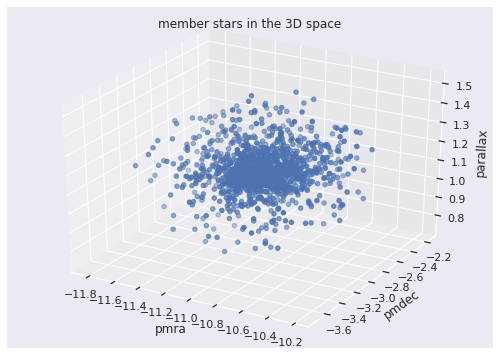

In [39]:
from mpl_toolkits.mplot3d import Axes3D


ax = plt.figure().gca(projection='3d')

ax.scatter(member.pmra, member.pmdec, member.parallax)
ax.set_xlabel('pmra')
ax.set_ylabel('pmdec')
ax.set_zlabel('parallax')
plt.title('member stars in the 3D space')
plt.show()


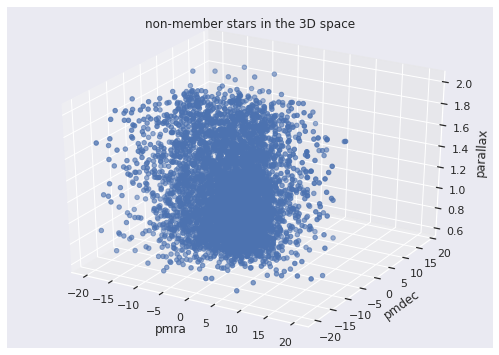

In [40]:
ax = plt.figure().gca(projection='3d')

ax.scatter(non_member.pmra, non_member.pmdec, non_member.parallax)
ax.set_xlabel('pmra')
ax.set_ylabel('pmdec')
ax.set_zlabel('parallax')
plt.title('non-member stars in the 3D space')
plt.show()


### Model Training and Prediction

In [50]:
base_model = RandomForestClassifier(n_estimators = 7000, 
                                    max_features = 4,
                                    oob_score = True, 
                                    random_state = 42)
base_model.fit(features, targets)


RandomForestClassifier(max_features=4, n_estimators=7000, oob_score=True,
                       random_state=42)

In [51]:
base_model.oob_score_

0.9988494175176182

In [52]:
from sklearn.metrics import precision_score
y_pred = base_model.predict(features)
precision_Gao = precision_score( y_true=targets, y_pred = y_pred)
precision_Gao

1.0

In [45]:
## chosing only GAIA stars close to 2.5 degree radius of the center

coordinate = coord.SkyCoord.from_name('M67')
print(coordinate)
radius = u.Quantity(2.5, u.deg)
Gaia.ROW_LIMIT = -1
# table = "gaiaedr3.gaia_source"
table = "gaiadr2.gaia_source"
j = Gaia.cone_search_async(coordinate, radius)
r = j.get_results()
print(type(r))

<SkyCoord (ICRS): (ra, dec) in deg
    (132.846, 11.814)>
INFO: Query finished. [astroquery.utils.tap.core]
<class 'astropy.table.table.Table'>


In [53]:
GAIA_target_stars = r.to_pandas()

GAIA_target_stars = GAIA_target_stars[GAIA_target_stars['parallax'] >= 0]

GAIA_target_stars = GAIA_target_stars[GAIA_target_stars.loc[:, 'bp_rp'].notnull()]

GAIA_target_stars = GAIA_target_stars[(abs(GAIA_target_stars['pmra']) < 20) & (abs(GAIA_target_stars['pmdec']) < 20)]

GAIA_target_stars.describe()

,solution_id,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_weight_al,astrometric_pseudo_colour,astrometric_pseudo_colour_error,mean_varpi_factor_al,astrometric_matched_observations,visibility_periods_used,...,phot_bp_mean_flux_over_error,phot_bp_mean_mag,phot_rp_n_obs,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_rp_excess_factor,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,rv_nb_transits,rv_template_teff,rv_template_logg,rv_template_fe_h,l,b,ecl_lon,ecl_lat,priam_flags,teff_val,teff_percentile_lower,teff_percentile_upper,a_g_val,a_g_percentile_lower,a_g_percentile_upper,e_bp_min_rp_val,e_bp_min_rp_percentile_lower,e_bp_min_rp_percentile_upper,flame_flags,radius_val,radius_percentile_lower,radius_percentile_upper,lum_val,lum_percentile_lower,lum_percentile_upper,dist
count,7.098700e+04,7.098700e+04,7.098700e+04,70987.0,70987.000000,70987.000000,70987.000000,70987.000000,70987.000000,70987.000000,70987.000000,70987.000000,70987.000000,70987.000000,70987.000000,70987.000000,70987.000000,70987.000000,70987.000000,70987.000000,70987.000000,70987.000000,70987.000000,70987.000000,70987.000000,70987.000000,70987.000000,70987.000000,70987.000000,70987.000000,7.098700e+04,70987.000000,70987.000000,70987.0,70987.000000,70907.000000,70907.000000,70987.000000,70987.000000,70987.000000,...,70987.000000,70987.000000,70987.000000,7.098700e+04,70987.000000,70987.000000,70987.000000,70987.000000,70987.000000,70987.000000,70987.000000,70987.000000,1150.000000,1150.000000,70987.000000,1150.000000,1150.000000,1150.000000,70987.000000,70987.000000,70987.000000,70987.000000,19091.000000,19091.000000,19091.000000,19091.000000,14780.000000,14780.000000,14780.000000,14780.000000,14780.000000,14780.000000,14337.0,14337.000000,14337.000000,14337.000000,14337.000000,14337.000000,14337.000000,70987.000000
mean,1.635721e+18,6.031195e+17,8.493591e+08,2015.5,132.757990,0.356870,11.776840,0.238726,1.040891,0.442350,7.285448,-3.021211,0.733304,-3.653886,0.487744,-0.347930,-0.221725,-0.262136,0.171983,0.224113,0.273509,-0.671809,0.438712,-0.148860,-0.407236,303.598758,6.434756,301.622424,1.976334,1.918318,4.656566e+02,0.351893,4.604504,31.0,10.879716,1.467851,0.060933,0.025179,34.815530,11.966261,...,153.534576,18.793224,32.661558,2.382657e+04,46.985300,243.906891,17.290871,1.403405,0.016073,1.502459,0.641631,0.860833,22.691065,1.338720,0.202488,5393.217285,3.643478,-0.094565,215.685386,31.819903,131.902155,-5.657650,100021.712011,5347.558594,5160.619141,5624.434570,0.347589,0.201034,0.544336,0.172374,0.099434,0.269887,200111.0,1.530959,1.411662,1.629827,4.420034,3.915124,4.924970,1.628621
std,0.000000e+00,3.772720e+15,4.885702e+08,0.0,1.253718,0.372633,1.233941,0.254779,0.896286,0.458192,12.647858,5.810404,0.752267,5.417125,0.531030,0.153137,0.174651,0.174069,0.194524,0.203885,0.176033,0.116651,0.176366,0.215122,0.133001,64.310980,43.706676,63.912063,2.325105,8.808780,5.203416e+03,0.705065,106.483105,0.0,41.923058,0.143617,0.060253,0.048247,7.266984,1.258506,...,265.942200,2.213848,7.294334,9.805792e+05,2736.694237,367.252655,1.925121,0.229112,0.125759,0.585034,0.343229,0.295831,33.306722,1.703387,1.658830,646.623230,0.713741,0.332335,1.450804,1.228807,1.233214,1.234005,202.287314,669.781311,643.016357,745.895874,0.350614,0.275729,0.429756,0.174909,0.136835,0.215108,0.0,2.990820,2.782772,3.180019,32.316772,28.910522,35.820766,0.620369
min,1.635721e+18,5.972678e+17,2.351200e+04,2015.5,130.293414,0.016709,9.317264,0.010515,0.

In [54]:
GAIA_target_stars = GAIA_target_stars.dropna(subset = feature_columns)
len(GAIA_target_stars)

70987

In [55]:
# select the set of predictor variables from the new dataset
new_features = GAIA_target_stars.loc[:, feature_columns]
new_features = new_features.astype('float32')

In [56]:
# estimate the membership classification of the stars
GAIA_target_stars['member'] = base_model.predict(new_features)
GAIA_target_stars['member'].value_counts()

0    69394
1     1593
Name: member, dtype: int64

### Comparing with Gao Paper

#### Members

Number of members found by Gao with a RF model with n_estimators = 7000:
* n(PMemb >= 0.6) = 1502
* n(PMemb >= 0.8) = 1361

In [57]:
# estimate the membership probability of the stars
# here we used n_estimators = 7000
GAIA_target_stars['PMemb'] = base_model.predict_proba(new_features)[:,1]
print('n(PMemb >= 0.6) =', sum(GAIA_target_stars['PMemb'] >= 0.6))
print('n(PMemb >= 0.8) =', sum(GAIA_target_stars['PMemb'] >= 0.8))

n(PMemb >= 0.6) = 1528
n(PMemb >= 0.8) = 1377


In [58]:
potentialMember = GAIA_target_stars[GAIA_target_stars['PMemb'] >= 0.6]
len(potentialMember)

1528

In [59]:
potentialMember.describe()

,solution_id,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_weight_al,astrometric_pseudo_colour,astrometric_pseudo_colour_error,mean_varpi_factor_al,astrometric_matched_observations,visibility_periods_used,...,phot_rp_n_obs,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_rp_excess_factor,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,rv_nb_transits,rv_template_teff,rv_template_logg,rv_template_fe_h,l,b,ecl_lon,ecl_lat,priam_flags,teff_val,teff_percentile_lower,teff_percentile_upper,a_g_val,a_g_percentile_lower,a_g_percentile_upper,e_bp_min_rp_val,e_bp_min_rp_percentile_lower,e_bp_min_rp_percentile_upper,flame_flags,radius_val,radius_percentile_lower,radius_percentile_upper,lum_val,lum_percentile_lower,lum_percentile_upper,dist,member,PMemb
count,1.528000e+03,1.528000e+03,1.528000e+03,1528.0,1528.000000,1528.000000,1528.000000,1528.000000,1528.000000,1528.000000,1528.000000,1528.000000,1528.000000,1528.000000,1528.000000,1528.000000,1528.000000,1528.000000,1528.000000,1528.000000,1528.000000,1528.000000,1528.000000,1528.000000,1528.000000,1528.000000,1528.000000,1528.000000,1528.000000,1528.000000,1528.000000,1528.000000,1.528000e+03,1528.0,1528.000000,1528.000000,1528.000000,1528.000000,1528.000000,1528.000000,...,1528.000000,1.528000e+03,1528.000000,1528.000000,1528.000000,1528.000000,1528.000000,1528.000000,1528.000000,1528.000000,86.000000,86.000000,1528.000000,86.000000,86.000000,86.000000,1528.000000,1528.000000,1528.000000,1528.000000,1019.000000,1019.000000,1019.000000,1019.000000,795.000000,795.000000,795.000000,795.000000,795.000000,795.000000,1008.0,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1528.000000,1528.0,1528.000000
mean,1.635721e+18,6.041452e+17,8.314573e+08,2015.5,132.859544,0.093995,11.816849,0.061944,1.120995,0.118821,19.997862,-10.988787,0.197002,-2.941534,0.135489,-0.300798,-0.218433,-0.225816,0.115461,0.203659,0.257316,-0.651425,0.388576,-0.094083,-0.403677,319.064791,32.449607,316.884817,2.179974,0.708886,342.304230,0.084345,5.804439e-01,31.0,46.800762,1.498977,0.016990,0.037764,36.402487,12.360602,...,34.918848,6.332324e+04,62.321915,672.703918,15.047591,1.300282,0.078534,1.386554,0.634604,0.751950,34.485995,2.116960,0.635471,5313.953613,3.372093,-0.052326,215.694310,31.933098,131.988053,-5.595562,100005.043180,5362.466309,5176.041992,5611.016113,0.370772,0.210025,0.575820,0.183342,0.102930,0.283837,200111.0,1.543801,1.425414,1.655418,4.280391,4.014855,4.545925,0.432759,1.0,0.952558
std,0.000000e+00,2.318213e+15,4.811881e+08,0.0,0.451500,0.105625,0.443558,0.071919,0.156326,0.133918,13.214281,0.288049,0.220284,0.259327,0.155622,0.100083,0.127636,0.129169,0.134315,0.159049,0.115625,0.083011,0.155755,0.186492,0.096641,35.118497,94.102336,34.877236,2.466210,4.133621,181.238510,0.213332,2.947877e+00,0.0,78.353935,0.107121,0.019248,0.032131,3.917241,0.731152,...,4.426356,4.877167e+05,534.650419,552.864319,2.005365,0.114873,0.269098,0.555105,0.302788,0.257084,4.032350,2.874862,2.792304,698.934143,0.707880,0.263227,0.527432,0.437711,0.447369,0.440261,88.556765,684.670044,655.810974,749.632690,0.304985,0.242199,0.371125,0.151798,0.118154,0.184605,0.0,2.865541,2.692704,3.057625,27.376322,25.798944,28.954882,0.452571,0.0,0.093456
min,1.635721e+18,5.975889e+17,1.427216e+06,2015.5,130.396966,0.018080,9.365995,0.011963,0.098562,0.021383,0.317539,-11.821615,0.037657,-3.719470,0.025969,-0.795347,-0.810287,-0.644119,-0.448784,-0.407458,-0.340119,-0.907704,-0.

In [60]:
member.describe()

,solution_id,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_weight_al,astrometric_pseudo_colour,astrometric_pseudo_colour_error,mean_varpi_factor_al,astrometric_matched_observations,visibility_periods_used,...,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_rp_excess_factor,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,rv_nb_transits,rv_template_teff,rv_template_logg,rv_template_fe_h,l,b,ecl_lon,ecl_lat,priam_flags,teff_val,teff_percentile_lower,teff_percentile_upper,a_g_val,a_g_percentile_lower,a_g_percentile_upper,e_bp_min_rp_val,e_bp_min_rp_percentile_lower,e_bp_min_rp_percentile_upper,flame_flags,radius_val,radius_percentile_lower,radius_percentile_upper,lum_val,lum_percentile_lower,lum_percentile_upper,dist,distance_pc,PMemb,gmm_label
count,1.260000e+03,1.260000e+03,1.260000e+03,1260.0,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1.260000e+03,1260.0,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,...,1.260000e+03,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,81.000000,81.000000,1260.000000,81.000000,81.000000,81.000000,1260.000000,1260.000000,1260.000000,1260.000000,918.000000,918.000000,918.000000,918.000000,714.000000,714.000000,714.000000,714.000000,714.000000,714.000000,908.0,908.000000,908.000000,908.000000,908.000000,908.000000,908.000000,1260.000000,1260.000000,1260.000000,1260.0
mean,1.635721e+18,6.043315e+17,8.375254e+08,2015.5,132.858128,0.078543,11.836845,0.051638,1.139731,0.099161,21.752031,-10.983373,0.164741,-2.941900,0.114083,-0.297659,-0.215406,-0.222145,0.110224,0.198607,0.254194,-0.648735,0.380506,-0.085988,-0.404697,318.717460,36.950794,316.522222,2.195238,0.633236,341.435181,0.062393,5.612299e-01,31.0,52.704987,1.513206,0.014236,0.038033,36.365873,12.393651,...,7.331929e+04,71.758632,732.850220,14.777440,1.285344,0.085714,1.309880,0.592260,0.717620,34.461042,2.159830,0.725397,5314.814941,3.333333,-0.055556,215.672495,31.940851,131.981303,-5.577042,100005.474946,5373.832031,5184.782715,5623.361328,0.375218,0.213191,0.582448,0.185773,0.104560,0.287158,200111.0,1.578989,1.457888,1.694436,4.519963,4.242636,4.797292,0.286370,885.064305,0.994601,0.0
std,0.000000e+00,1.939145e+15,4.803576e+08,0.0,0.258130,0.089316,0.242974,0.060359,0.104531,0.113656,12.871785,0.259065,0.186985,0.229453,0.135045,0.096837,0.124214,0.127356,0.131798,0.152010,0.111192,0.081486,0.152455,0.182208,0.094062,31.186663,99.269136,31.021763,2.485537,4.357537,192.577515,0.174547,3.058809e+00,0.0,81.982697,0.100181,0.016307,0.031382,3.430732,0.664993,...,5.348156e+05,587.898611,553.565796,1.946592,0.104437,0.280053,0.521645,0.282529,0.243315,4.121381,2.934836,2.949803,709.068298,0.693722,0.270994,0.294356,0.245891,0.256529,0.240140,93.296147,689.936584,660.792969,754.263184,0.310228,0.246283,0.378478,0.154454,0.120215,0.188414,0.0,2.982491,2.801324,3.183924,28.733906,27.078060,30.390810,0.203599,85.129233,0.008668,0.0
min,1.635721e+18,5.986712e+17,1.427216e+06,2015.5,132.008433,0.018080,10.993079,0.011963,0.742061,0.021383,0.973774,-11.821615,0.037657,-3.719470,0.025969,-0.795347,-0.810287,-0.644119,-0.448784,-0.293585,-0.340119,-0.907704,-0.131954,

#### Figure 4
PMemb from RF as a function of G band Magnitude and distance from cluster center.

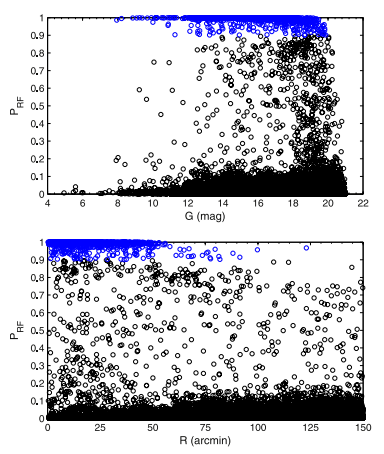

PMemb $\geq$ 0.9 are colored in blue.

In [61]:
sns.set(font_scale=1.1)

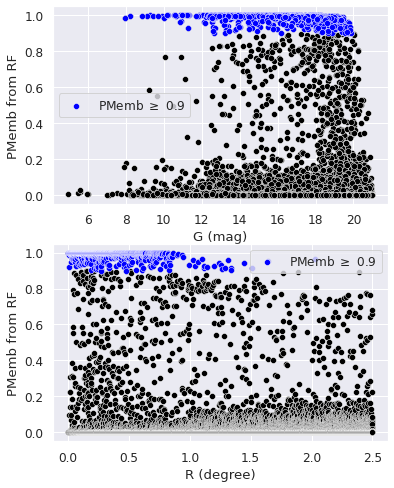

In [62]:
plt.figure(figsize = (6, 8))

PMemb_mask = GAIA_target_stars.PMemb >= 0.9
plt.subplot(211)
sns.scatterplot(x='phot_g_mean_mag', y = 'PMemb', data = GAIA_target_stars, 
                color = 'black')
sns.scatterplot(x='phot_g_mean_mag', y = 'PMemb', 
                data = GAIA_target_stars[PMemb_mask], 
                color = 'blue', label = 'PMemb $\geq$ 0.9')
plt.legend()
plt.xlabel('G (mag)')
plt.ylabel('PMemb from RF')
#plt.title('Member')

plt.subplot(212)
sns.scatterplot(x='dist', y = 'PMemb', data = GAIA_target_stars, 
                color = 'black')
sns.scatterplot(x='dist', y = 'PMemb', 
                data = GAIA_target_stars[PMemb_mask], 
                color = 'blue', label = 'PMemb $\geq$ 0.9')
plt.legend()
plt.xlabel('R (degree)')
plt.ylabel('PMemb from RF')
#plt.title('Non Member')
plt.show()

#### Figure 7: CMD

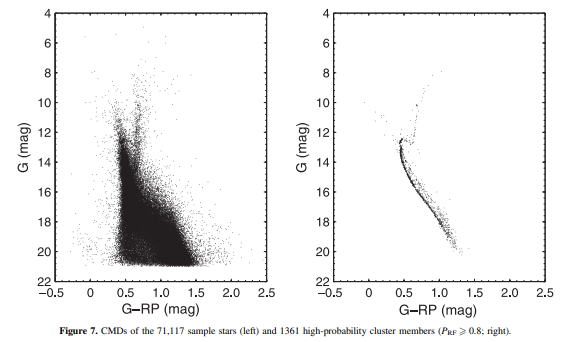

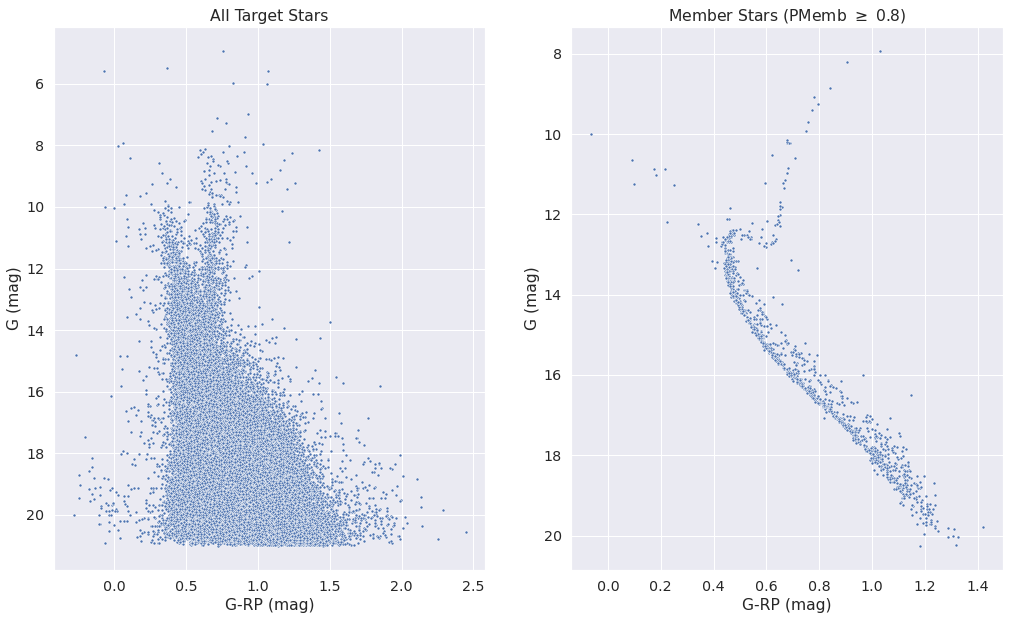

In [63]:
sns.set(font_scale=1.3)
fig, axes = plt.subplots(1, 2, figsize=(17,10))
#fig.suptitle('CMD of Training data for M67')

sns.scatterplot(x = 'g_rp', y='phot_g_mean_mag',
                data = GAIA_target_stars, ax = axes[0], marker = '.')
axes[0].set_title('All Target Stars')
axes[0].set_xlabel('G-RP (mag)')
axes[0].set_ylabel('G (mag)')
axes[0].invert_yaxis()

PMemb_mask = GAIA_target_stars.PMemb >= 0.8

sns.scatterplot(x = 'g_rp', y='phot_g_mean_mag', marker = '.',
                data = GAIA_target_stars[PMemb_mask], ax = axes[1])
axes[1].set_title('Member Stars (PMemb $\geq$ 0.8)')
axes[1].set_xlabel('G-RP (mag)')
axes[1].set_ylabel('G (mag)')
axes[1].invert_yaxis()

plt.show()


#### Figure 8
Comparison between GMM and RF membership probabilities

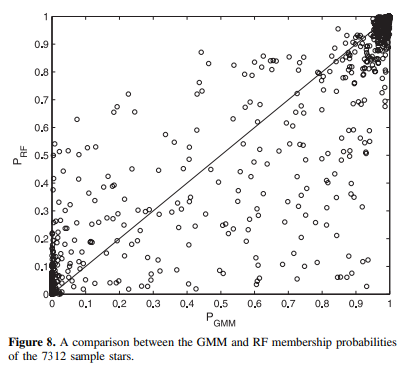

In [64]:
all_stars_feature = all_stars.loc[:, feature_columns]
all_stars['PMemb_RF'] = base_model.predict_proba(all_stars_feature)[:,1]

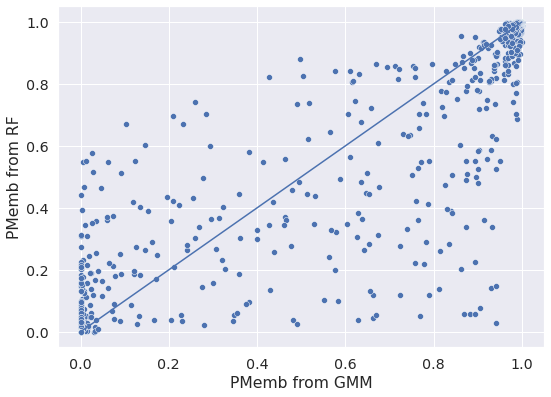

In [65]:
sns.scatterplot(x = 'PMemb', y = 'PMemb_RF', data = all_stars)
plt.ylabel('PMemb from RF')
plt.xlabel('PMemb from GMM')
plt.plot([0,1],[0,1])
plt.show()

### Distribution of the paramters

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

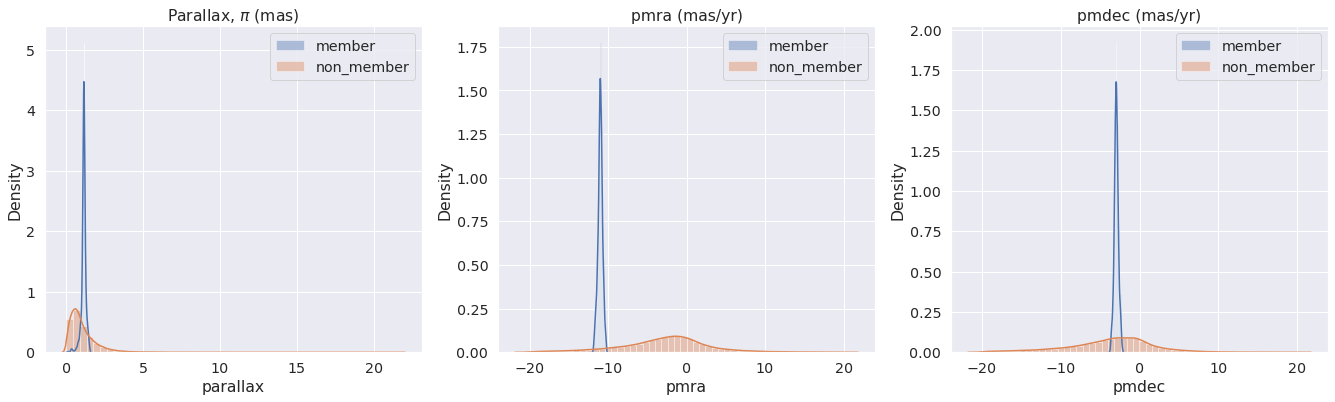

In [66]:
sns.set(font_scale=1.3)
plt.figure(figsize = (23,6))

member_mask = GAIA_target_stars.PMemb >= 0.6
field_mask = GAIA_target_stars.PMemb <= 0.4
member = GAIA_target_stars[member_mask]
non_member = GAIA_target_stars[field_mask]


plt.subplot(131)
sns.distplot(member.parallax, label='member')
sns.distplot(non_member.parallax, label = 'non_member')
plt.title('Parallax, $\pi$ (mas)')
plt.legend()

plt.subplot(132)
sns.distplot(member.pmra, label='member')
sns.distplot(non_member.pmra, label = 'non_member')
plt.title('pmra (mas/yr)')
plt.legend()

plt.subplot(133)
sns.distplot(member.pmdec, label='member')
sns.distplot(non_member.pmdec, label = 'non_member')
plt.title('pmdec (mas/yr)')
plt.legend()

plt.show()

#### Other Visualization

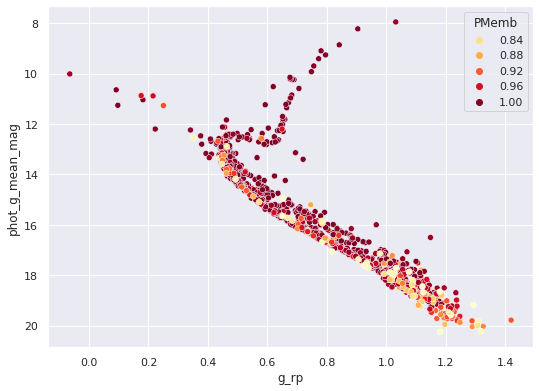

In [ ]:
# CMD of predicted members 

cmd = sns.scatterplot(x = 'g_rp', y = 'phot_g_mean_mag', hue= 'PMemb', 
                      palette='YlOrRd', data = GAIA_target_stars[GAIA_target_stars['PMemb'] >= 0.8] )
cmd.invert_yaxis()

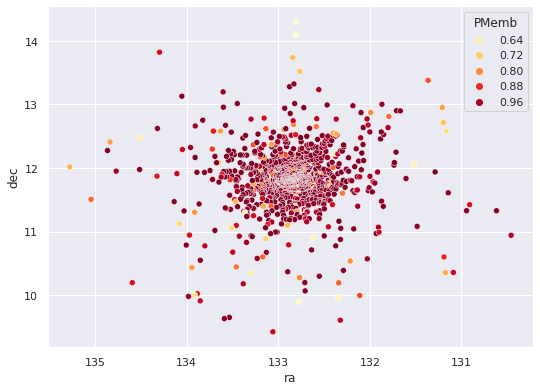

In [ ]:
skyplot = sns.scatterplot(x = 'ra', y = 'dec', hue= 'PMemb', 
                      palette='YlOrRd', data = GAIA_target_stars[GAIA_target_stars['PMemb'] >= 0.6] )
skyplot.invert_xaxis()
plt.show()


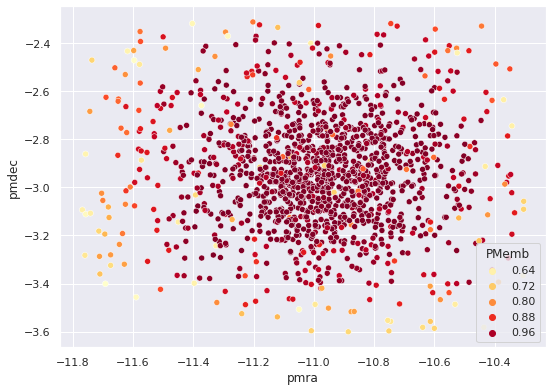

In [ ]:
# pm plot
sns.scatterplot(x = 'pmra', y = 'pmdec', hue= 'PMemb', 
                      palette='YlOrRd', data = GAIA_target_stars[GAIA_target_stars['PMemb'] >= 0.6] )
plt.show()


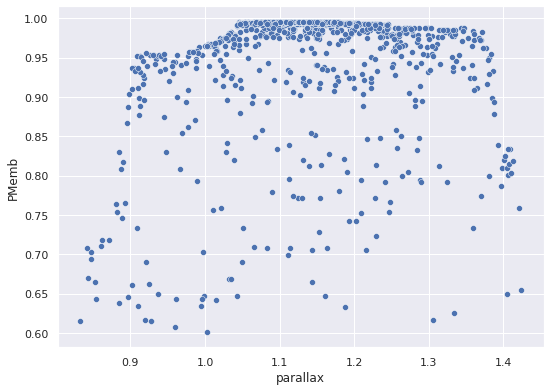

In [ ]:
# parallax plot
sns.scatterplot(x = 'parallax', y = 'PMemb',  
                      palette='YlOrRd', data = GAIA_target_stars[GAIA_target_stars['PMemb'] >= 0.6] )

In [ ]:
# saving the files as csv
# all_stars.to_csv('gaia_6405_membership_prob.csv')

potentialMember.to_csv('M_67_membership_prob.csv')
